# Bayesian Inference with PyMC - Allen Downey
+ [Notebooks](https://allendowney.github.io/BayesianInferencePyMC/index.html)
+ [Slides](https://docs.google.com/presentation/d/e/2PACX-1vRfzvjPnyBevd1VBt8yxwP23xuddrcYgu1mYOsTE9o_ViWJqoxWMhzgcw-FPhfeeobEbXYoeJvsPuQ-/pub#slide=id.p)

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import theano.tensor as tt
import bambi as bmb
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import plotnine as p9

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

DATA_DIR = PROJECT_DIR / 'scratchpads'  / 'data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/scratchpads/data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

pandas    : 1.3.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
arviz     : 0.11.2
matplotlib: 3.4.3
seaborn   : 0.11.2
plotnine  : 0.8.0
theano    : 1.1.2
scipy     : 1.7.1
pymc3     : 3.11.4
xarray    : 0.19.0
numpy     : 1.19.5
bambi     : 0.6.3



---

# 1. Estimating Rates

## Hockey

In [3]:
mu = 2.4
sample_poisson = pm.Poisson.dist(mu).random(size=1000)
sample_poisson.mean()
sample_poisson_df = pd.DataFrame(sample_poisson, columns=['goals'])
sample_poisson_df.head()

goals
0      5
1      0
2      2
3      3
4      4

In [4]:
print(sample_poisson_df['goals'].mean())

2.406


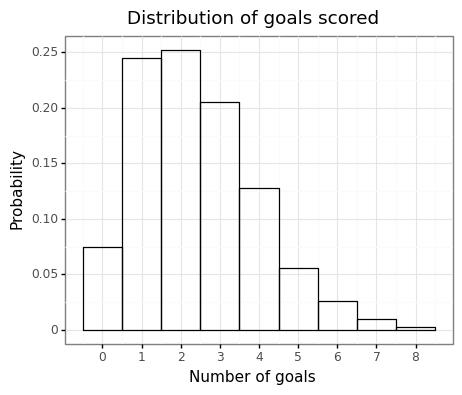

In [5]:
p = (ggplot(sample_poisson_df, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_poisson_df['goals'].max() + 1, color='black', fill='none') +
     labs(title="Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_poisson_df['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Gamma Distribution
+ Use gamma distribution to model mu - the goal scoring rate

In [6]:
alpha=4.6
beta = 1.9
sample_gamma = pm.Gamma.dist(alpha, beta).random(size=1000)
sample_gamma_df = pd.DataFrame(sample_gamma, columns=['sample_gamma'])
sample_gamma_df.head()

sample_gamma
0      0.870942
1      0.907795
2      0.991236
3      1.831153
4      2.042332

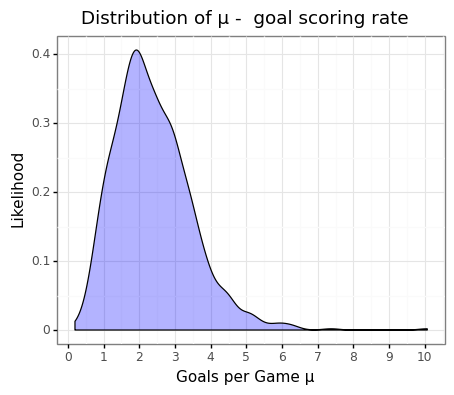

In [7]:
p = (ggplot(sample_gamma_df, aes('sample_gamma'))+
     geom_density(color='black', fill='blue', alpha=0.3) +
     labs(title="Distribution of μ -  goal scoring rate", x='Goals per Game μ', y='Likelihood') +
     scale_x_continuous(breaks=range(int(sample_gamma_df['sample_gamma'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Making a Model

In [8]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    trace1 = pm.sample_prior_predictive(1000)
    idata_model1 = az.from_pymc3(prior=trace1)

In [9]:
sample_prior_df = idata_model1.prior['mu'].to_dataframe().droplevel(0).reset_index()
sample_prior_df['mu'].mean()

2.4429690179668997

In [10]:
sample_prior_df.head()

draw        mu
0     0  2.049317
1     1  2.358949
2     2  1.459401
3     3  7.331837
4     4  4.135931

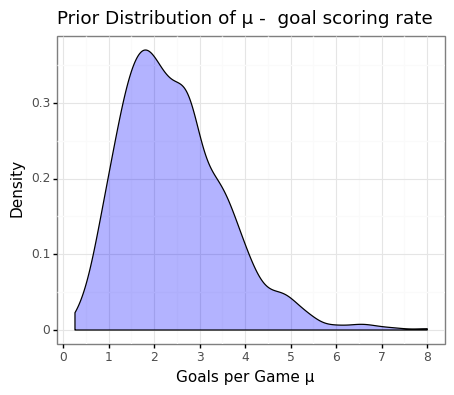

In [11]:
p = (ggplot(sample_prior_df, aes('mu'))+
     geom_density(color='black', fill='blue', alpha=0.3) +
     labs(title="Prior Distribution of μ -  goal scoring rate", x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Adding to the Model

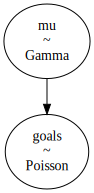

In [12]:
with pm.Model() as model2:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    prior_pred = pm.sample_prior_predictive(1000)
    idata_model2 = az.from_pymc3(prior=prior_pred)
pm.model_to_graphviz(model2)

In [13]:
sample_prior_df = idata_model2.prior['goals'].to_dataframe().droplevel(0)
sample_prior_df.head()

goals
draw       
0         1
1         4
2         7
3         2
4         1

In [14]:
sample_prior_df['goals'].mean()

2.412

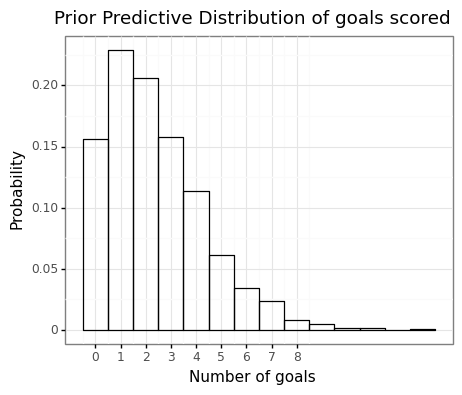

In [15]:
p = (ggplot(sample_prior_df, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_prior_df['goals'].max() + 1, color='black', fill='none') +
     labs(title="Prior Predictive Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_poisson_df['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ The prior predictive distribution has 2 sources of variation
    + mu - the mean goal scoring rate is estimated by samles drawn from a gamma distribution
    + This is fed to the poisson distribution which generates more variation by sampling from a poisson distribution with each value of mu
+ Below shows the means of the actual data compared to the model are similar
+ However the variation is more in the model

In [16]:
sample_poisson_df['goals'].mean() , sample_prior_df['goals'].mean()

(2.406, 2.412)

In [17]:
sample_poisson_df['goals'].std() , sample_prior_df['goals'].std()

(1.5419278652198816, 1.9844883960845412)

## When do we get to Inference?
+ Assume team A plays team B and scores 4 goals

In [18]:
with pm.Model() as model3:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)
    prior = pm.sample_prior_predictive()
    idata_model3 = az.from_pymc3(prior=prior, trace=trace)    

/tmp/ipykernel_1165209/1177847662.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [19]:
idata_model3

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [20]:
sample_prior_df = idata_model3.prior['mu'].to_dataframe()
sample_posterior_df = idata_model3.posterior['mu'].to_dataframe()
sample_posterior_df

mu
chain draw          
0     0     2.841000
      1     2.841000
      2     4.219644
      3     1.827119
      4     2.597564
...              ...
3     495   3.475730
      496   4.985552
      497   2.879751
      498   3.539654
      499   1.996133

[2000 rows x 1 columns]

In [21]:
sample_posterior_df['mu'].mean()

2.9632335308593407

In [22]:
sample_prior_df

mu
chain draw          
0     0     3.134741
      1     1.601161
      2     1.770331
      3     2.136558
      4     2.749368
...              ...
      495   3.084324
      496   2.672597
      497   2.446941
      498   3.755191
      499   1.142058

[500 rows x 1 columns]

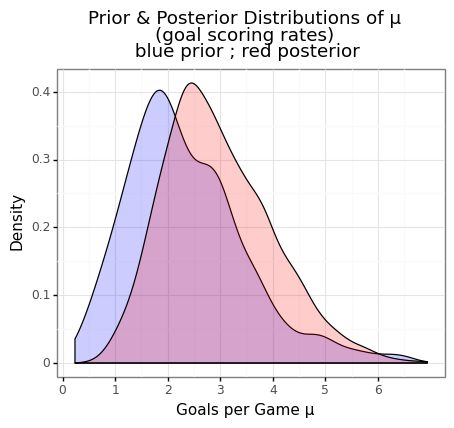

In [23]:
p = (ggplot() +
     geom_density(sample_prior_df, aes('mu'), color='black', fill='blue', alpha=0.2) +
     geom_density(sample_posterior_df, aes('mu'), color='black', fill='red', alpha=0.2) +
     labs(title="Prior & Posterior Distributions of μ\n(goal scoring rates)\n blue prior ; red posterior",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

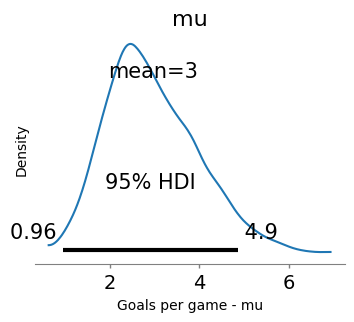

In [24]:
fig, ax = plt.subplots(figsize=(4,3))
az.plot_posterior(idata_model3, ax=ax, hdi_prob=0.95)
ax.set_ylabel('Density')
ax.set_xlabel('Goals per game - mu')
plt.show();

## Two Teams
+ Assume team A scores 5 goals and team B scores 1 goal

In [25]:
alpha = 4.6
beta = 1.9

In [26]:
with pm.Model() as model4:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5])
    goals_b = pm.Poisson('goals_B', mu_B, observed=[1])

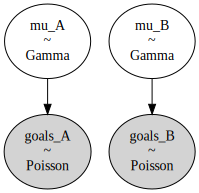

In [27]:
pm.model_to_graphviz(model4)

In [28]:
with model4:
    prior4 = pm.sample_prior_predictive()
    trace4 = pm.sample(500)
    idata_model4 = az.from_pymc3(prior=prior4, trace=trace4)

/tmp/ipykernel_1165209/1049241478.py:3: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


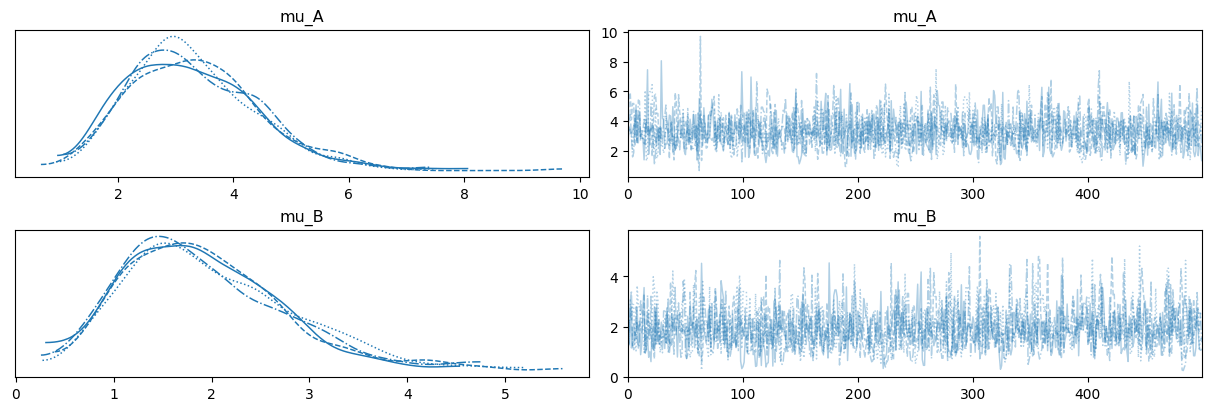

In [29]:
az.plot_trace(idata_model4);

In [30]:
mu_A_df = idata_model4.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model4.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.302171313321752, 1.9321530197033707)

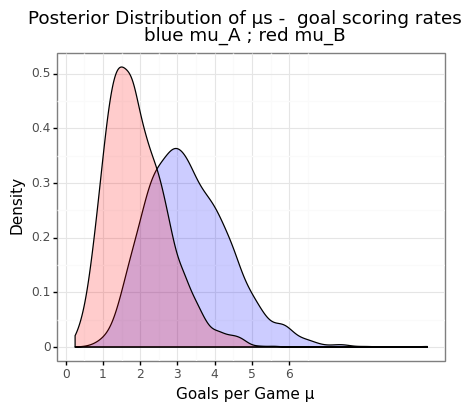

In [31]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='black', fill='blue', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='black', fill='red', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Probability of Superiority
+ chance that a random value from Team A posterior exceeds a random value from Team b posterior

In [32]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.855

## Exercise
Suppose the same teams play again and Team A wins 3-1. Modify the previous example to take into account both games. How much does the second game affect the posterior distributions and the probability of superiority?
+ First game: team A scores 5 goals and team B scores 1 goal
+ Second game: team A 3, team B 1

In [33]:
observed_A = [5, 3]
observed_B = [1, 1]

/tmp/ipykernel_1165209/4079462047.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


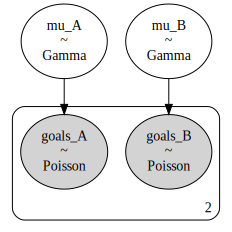

In [34]:
with pm.Model() as model5:
    
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    
    goals_A = pm.Poisson('goals_A', mu_A, observed=observed_A)
    goals_B = pm.Poisson('goals_B', mu_B, observed=observed_B)
    
    prior5 = pm.sample_prior_predictive()
    trace5 = pm.sample()
    idata_model5 = az.from_pymc3(prior=prior5, trace=trace5)
pm.model_to_graphviz(model5)

In [35]:
idata_model5

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

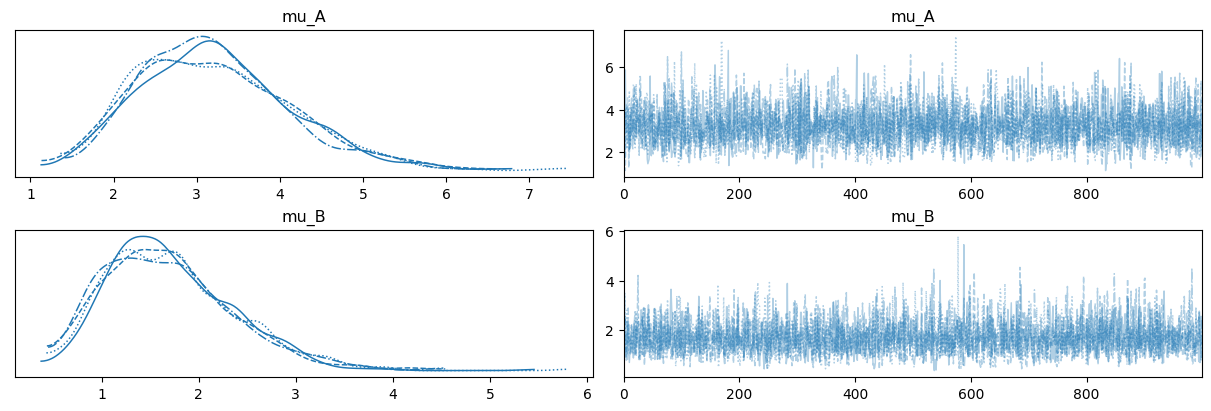

In [36]:
az.plot_trace(idata_model5);

In [37]:
mu_A_df = idata_model5.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model5.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.216523538133748, 1.7033860119348094)

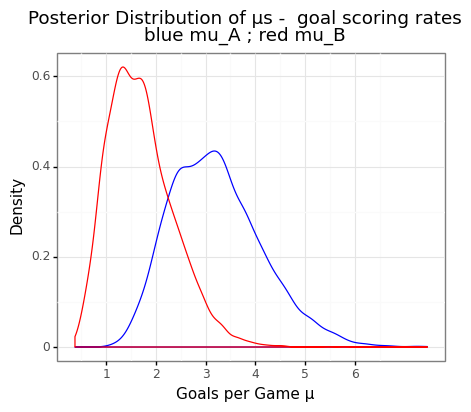

In [38]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='blue', fill='none', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='red', fill='none', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

In [39]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.9165

---

# 2. Making Predictions

## Prediction
+ What distribution of goals should we expect if the teams play a third game

In [40]:
alpha = 4.6
beta = 1.9

In [41]:
with pm.Model() as model1:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace1 = pm.sample(500)
    idata_model1 = az.from_pymc3(trace=trace1)

/tmp/ipykernel_1165209/4157314536.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [42]:
sample_posterior = idata_model1.posterior['mu'].to_dataframe().reset_index()
len(sample_posterior)

2000

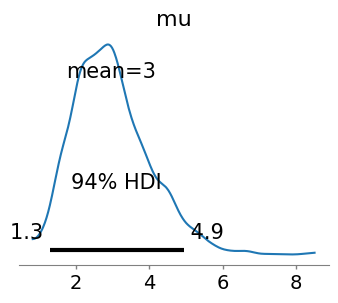

In [43]:
fig, ax = plt.subplots(figsize=(4,3))
az.plot_posterior(idata_model1.posterior['mu'], ax=ax)
plt.show();

## Posterior Predictive Distribution

In [44]:
with model1:
    post_pred = pm.sample_posterior_predictive(trace1)
    idata_model1.extend(az.from_pymc3(posterior_predictive=post_pred))

In [45]:
idata_model1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [46]:
sample_post_pred = idata_model1.posterior_predictive['goals'].to_dataframe().reset_index()
sample_post_pred
# sample_post_pred['goals'].mean()

chain  draw  goals
0         0     0      4
1         0     1      4
2         0     2      4
3         0     3      3
4         0     4      7
...     ...   ...    ...
1995      0  1995      3
1996      0  1996      3
1997      0  1997      1
1998      0  1998      8
1999      0  1999      2

[2000 rows x 3 columns]

In [47]:
sample_post_pred['goals'].mean()

2.9665

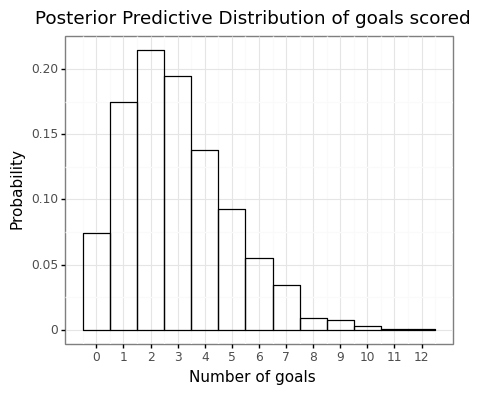

In [48]:
p = (ggplot(sample_post_pred, aes('goals', after_stat('density')))+
     geom_histogram(bins=sample_post_pred['goals'].max() + 1, color='black', fill='none') +
     labs(title="Posterior Predictive Distribution of goals scored", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(sample_post_pred['goals'].max() + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

## Two Teams
+ Two games are played A vs B with scores 5-1 and 3-1

In [49]:
with pm.Model() as model2:
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5,3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1,1])
    trace2 = pm.sample(500)
    idata_model2 = az.from_pymc3(trace=trace2)

/tmp/ipykernel_1165209/3643561010.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


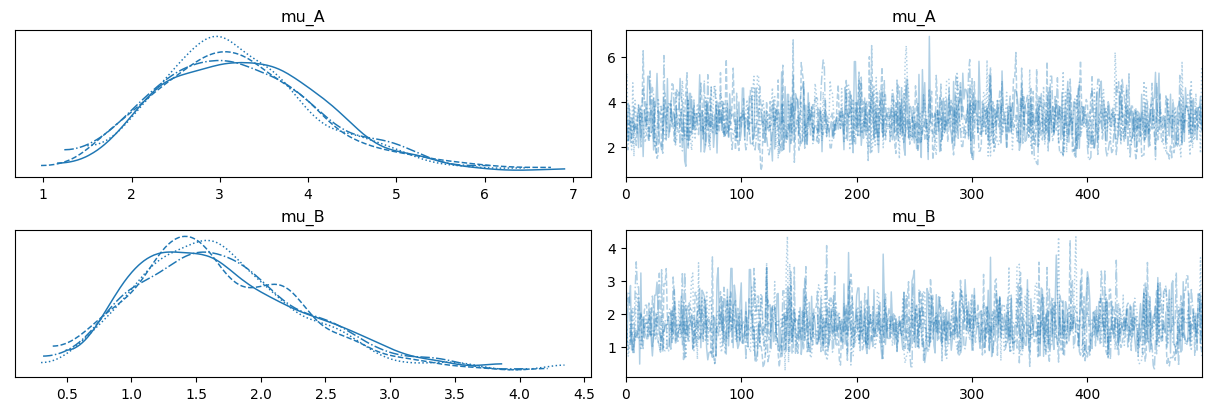

In [50]:
az.plot_trace(idata_model2)
plt.show();

In [51]:
idata_model2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [52]:
mu_A_df = idata_model2.posterior['mu_A'].to_dataframe()
mu_B_df = idata_model2.posterior['mu_B'].to_dataframe()
mu_A_df['mu_A'].mean() , mu_B_df['mu_B'].mean()

(3.2288643266138375, 1.6943673392447296)

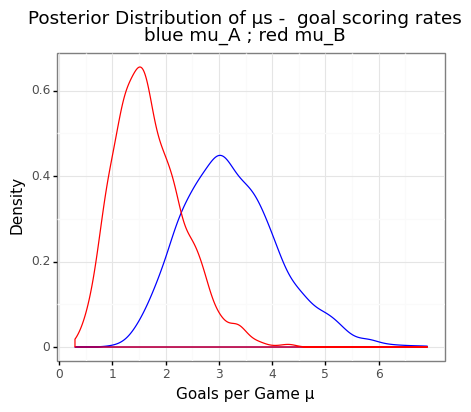

In [53]:
p = (ggplot() +
     geom_density(mu_A_df, aes('mu_A'), color='blue', fill='none', alpha=0.2) +
     geom_density(mu_B_df, aes('mu_B'), color='red', fill='none', alpha=0.2) +
     labs(title="Posterior Distribution of μs -  goal scoring rates\nblue mu_A ; red mu_B",
          x='Goals per Game μ', y='Density') +
     scale_x_continuous(breaks=range(int(sample_prior_df['mu'].max()) + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ Probability of superiority

In [54]:
(mu_A_df['mu_A'] > mu_B_df['mu_B']).mean()

0.917

## Predictions

In [55]:
with model2:
    post_pred = pm.sample_posterior_predictive(trace2)
    idata_model2.extend(az.from_pymc3(posterior_predictive=post_pred))

In [56]:
idata_model2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> posterior_predictive

In [57]:
goals_A_df = idata_model2.posterior_predictive['goals_A'].to_dataframe().reset_index()[['goals_A']]
goals_B_df = idata_model2.posterior_predictive['goals_B'].to_dataframe().reset_index()[['goals_B']]
max_goals = max(goals_A_df['goals_A'].max(), goals_B_df['goals_B'].max())
print(max_goals)
goals_A_df

15


goals_A
0           6
1           8
2           4
3           2
4           3
...       ...
3995        1
3996        5
3997        2
3998        1
3999        1

[4000 rows x 1 columns]

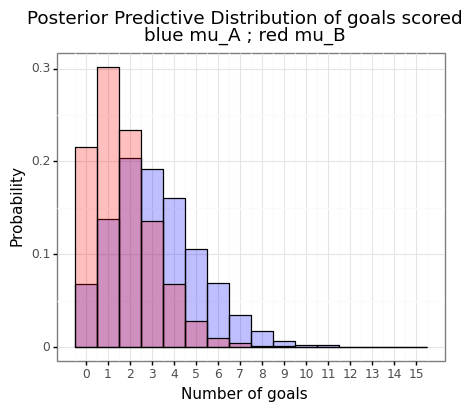

In [58]:
p = (ggplot() +
     geom_histogram(goals_A_df, aes('goals_A', after_stat('density')), bins=max_goals + 1, color='black', fill='blue', alpha=0.25) +
     geom_histogram(goals_B_df, aes('goals_B', after_stat('density')), bins=max_goals + 1, color='black', fill='red', alpha=0.25) +
     labs(title="Posterior Predictive Distribution of goals scored\nblue mu_A ; red mu_B", x='Number of goals', y='Probability') +
     scale_x_continuous(breaks=range(max_goals + 1)) +
     theme(figure_size=(5,4))
    )
p.draw();

+ Team B  more likely to score 0, 1, 2 goals
+ Team A more likely to score 3 or more
+ Chance that A wins next game

In [59]:
p_A_win = (goals_A_df['goals_A'] > goals_B_df['goals_B']).mean()
p_A_win

0.6485

In [60]:
p_A_lose = (goals_A_df['goals_A'] < goals_B_df['goals_B']).mean()
p_A_lose

0.19825

In [61]:
p_draw = (goals_A_df['goals_A'] == goals_B_df['goals_B']).mean()
p_draw

0.15325

## Sudden Death
+ In overtime, first team to score wins the game
+ For a poisson process, the time to next event is 1/mu
+ Sample from the posterior predictive distribution to for time until next goal in units of games

In [62]:
t_A = pm.Exponential.dist(mu_A_df['mu_A'].values).random(1000)
t_A.mean()

0.3397736168326994

In [63]:
t_B = pm.Exponential.dist(mu_B_df['mu_B'].values).random(1000)
t_B.mean()

0.6913638702628169

+ On average, it will take longer for team B to score than team B - about 0.4 game lengths longer

## Exercise
1. Compute probability Team A wins in o/t, then compute their total probability of winning the next game
2. What is Team A's probability of winning at least 2 of the remaining 5 games in the series.
    + Hint use `pm.Binomial.dist` to draw a sample of wins from a binomial dist. with `n=5` and `p=prob_win`

### Ex 1

In [64]:
# Assume being in overtime means the game finishes after the first team scores
# ie where t_A < t_B means team A has scored before team B would have scored and the game is stopped
A_winot = (t_A < t_B).sum() / len(t_A)
print(A_winot)

0.636


In [65]:
# Total probability of team A winning 
# 4 possible paths through the game to get 2 outcomes - A win, or B win 
# Path 1: team A wins outright, team B loses - 0.67425 - 0.67425
# Path 2: team A loses, B wins - 0.1845 - 0.1845
# Paths 3: Draw and go to overtime. In o/t team A wins - 0.14125 x 0.6525 - 0.0922
# Path 4: Draw and go to o/t team A loses B wins - 0.14125 x (1 - 0.6525) - 0.0491
# total: 0.6745 + 0.1845 + 0.0922 + 0.0491 = 1.0
# p(team A wins) = 0.67425 + 0.0922 = 0.76645
prob_win = p_A_win + A_winot * p_draw
print(prob_win)

0.7459669999999999


### Ex 2

In [66]:
# sample_poisson = pm.Poisson.dist(mu).random(size=1000)
binom_dist = pm.Binomial.dist(n=5, p=prob_win).random(size=1000)
(binom_dist >= 2).sum()/len(binom_dist)

0.99

---

# 3. Estimating Proportions

```
When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110. ‘It looks very suspicious to me,’ said Barry Blight, a statistics lecturer at the London School of Economics. ‘If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.’
```
 Does these mean the coin is biased rather than fair?

## Binomial Distribution
+ We know a coin is fair
+ We toss it 250 times
+ We model this with a binomial distribution, `n=250`, `p=0.5`

In [67]:
n=250
p=0.5

In [68]:
sample_binomial = pm.Binomial.dist(n, p).random(size=1000)
sample_binomial.mean()

125.06

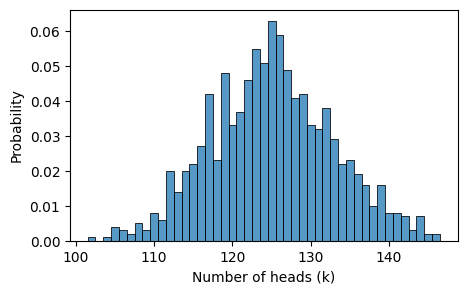

In [69]:
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(sample_binomial, ax=ax, stat='probability', discrete=True)
ax.set_xlabel('Number of heads (k)')
ax.set_ylabel('Probability')
plt.show();

## Beta Distribution

In [70]:
alpha = 2
beta = 2

In [71]:
sample_beta = pm.Beta.dist(alpha=alpha, beta=beta).random(size=1000)
sample_beta.mean()

0.4936633369450957

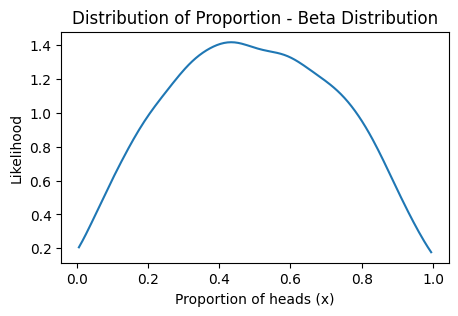

In [72]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(sample_beta, cut=0.0)
ax.set_xlabel('Proportion of heads (x)')
ax.set_ylabel('Likelihood')
ax.set_title('Distribution of Proportion - Beta Distribution')
plt.show();

## Beta Binomial Model
+ `x` - probability of heads
+ `k` - number of heads

In [73]:
alpha= 2
beta = 2
n = 250

In [74]:
with pm.Model() as model1:
    x = pm.Beta('x', alpha=alpha, beta=beta)
    k = pm.Binomial('k', n=n, p=x)
    trace1 = pm.sample_prior_predictive(1000)

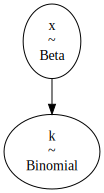

In [75]:
pm.model_to_graphviz(model1)

In [76]:
sample_prior = trace1['x']
sample_prior.mean()

0.5091978922838423

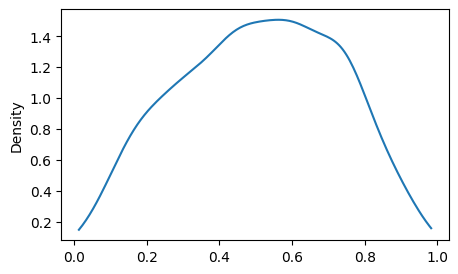

In [77]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(sample_prior, cut=0.0);

+ This is our prior belief about coins - most coins are close to fair, but some are strongly biased with x values close to 0 and 1

In [78]:
### Prior Predictive Distribution

In [79]:
sample_prior_pred = trace1['k']
sample_prior_pred.mean()

127.241

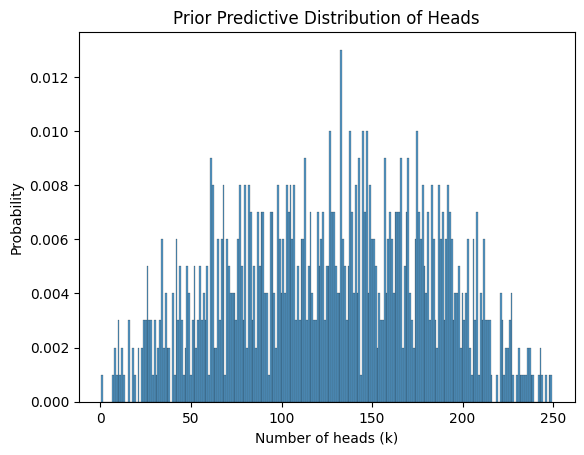

In [80]:
fig, ax = plt.subplots()
sns.histplot(sample_prior_pred, discrete=True, stat='probability', ax=ax)
ax.set_title('Prior Predictive Distribution of Heads')
ax.set_xlabel('Number of heads (k)')
plt.show();

### Inference

In [81]:
k_obs = 140

In [82]:
with pm.Model() as model2:
    x = pm.Beta('x', alpha=2, beta=2)
    k = pm.Binomial('k', n=n, p=x, observed=k_obs)
    trace2 = pm.sample(500)

/tmp/ipykernel_1165209/2015590335.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


In [83]:
len(trace2['x'])

2000

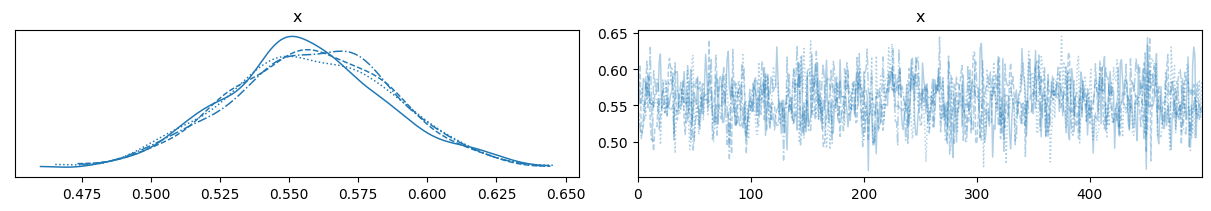

In [84]:
with model2:
    az.plot_trace(trace2)

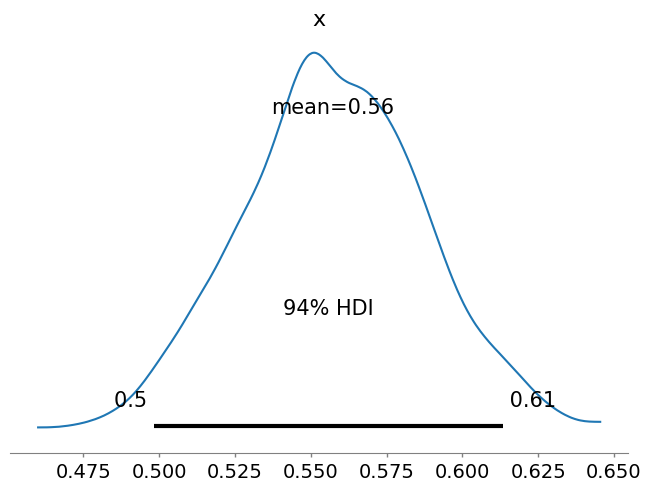

In [85]:
with model2:
    az.plot_posterior(trace2)

In [86]:
with model2:
    posterior_pred_trace = pm.sample_posterior_predictive(trace2, 500)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample


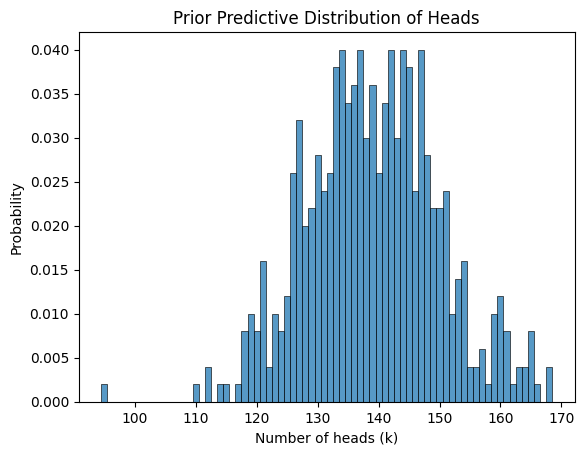

In [87]:
fig, ax = plt.subplots()
sns.histplot(posterior_pred_trace['k'], discrete=True, stat='probability', ax=ax)
ax.set_title('Prior Predictive Distribution of Heads')
ax.set_xlabel('Number of heads (k)')
plt.show();

---

# 4. Hierarchical Models

### Two Coins
+ Spin each coin 250 times
+ First one comes up heads 140 times
+ Second one comes up heads 120 times

In [88]:
n = 250

with pm.Model() as model1:
    x1 = pm.Beta('x1', alpha=2, beta=2)
    x2 = pm.Beta('x2', alpha=2, beta=2)
    
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=120)

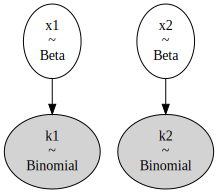

In [89]:
pm.model_to_graphviz(model1)

In [90]:
with model1:
    trace1 = pm.sample(500)

/tmp/ipykernel_1165209/3897402625.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


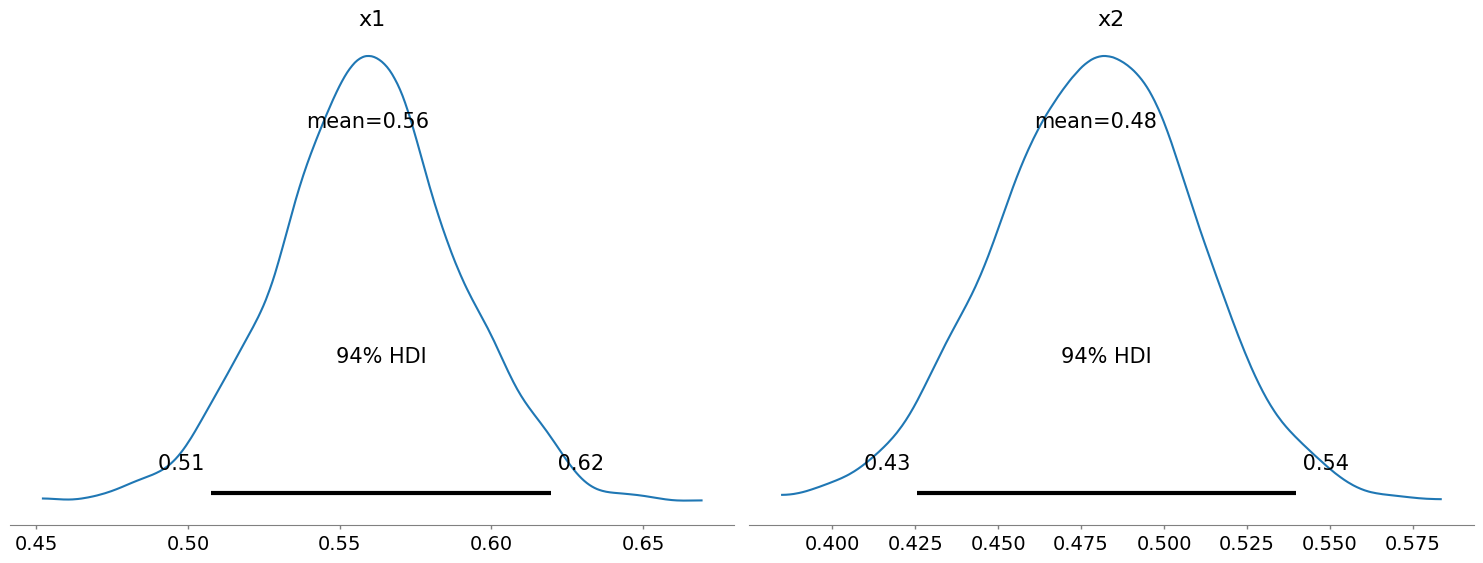

In [91]:
with model1:
    az.plot_posterior(trace1)

+ The data we have about each coin provides 2 types of information:
    + about each coin specifically
    + about coins in general
    + By estimating `x1` and `x2` sparately we are using the first kind of information, but not the second
+ An alternative is to use a hierarchical model

#### Going Hierarchical
+ Instead of defining the beta distribution parameters, we can add the beta distribution to the model, and use the data to estimate them

In [92]:
with pm.Model() as model2:
    alpha=pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    
    x1 = pm.Beta('x1', alpha=alpha, beta=beta)
    x2 = pm.Beta('x2', alpha=alpha, beta=beta)
    
    k1 = pm.Binomial('k1', n=n, p=x1, observed=140)
    k2 = pm.Binomial('k2', n=n, p=x2, observed=110)

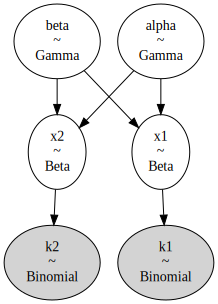

In [93]:
pm.model_to_graphviz(model2)

+ The model has 3 levels:
    + top level - `alpha`, `beta` are **hyperpriors** drawn from 2 gamma distributions which are called **hyperprior distributions**
    + Next level - the hyperpriors are used to define the prio distributions `x1` and `x2`
    + At the lowest level, the parameters are used to define the distributions of `k1` and `k2`

In [94]:
with model2:
    trace2 = pm.sample_prior_predictive(500)

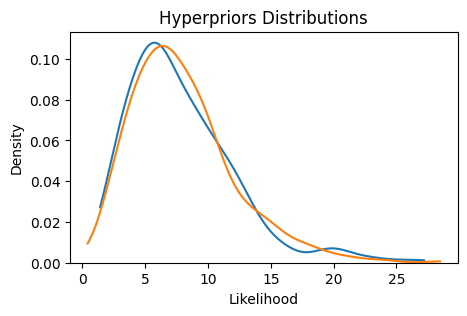

In [95]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(trace2['alpha'], ax=ax, cut=0.0)
sns.kdeplot(trace2['beta'], ax=ax, cut=0.0)
ax.set_title('Hyperpriors Distributions')
ax.set_xlabel('Likelihood')
plt.show();

In [96]:
sample_prior_x1 = trace2['x1']
sample_prior_x2 = trace2['x2']
sample_prior_x1.mean(), sample_prior_x2.mean()

(0.49422705576222353, 0.49905378679072976)

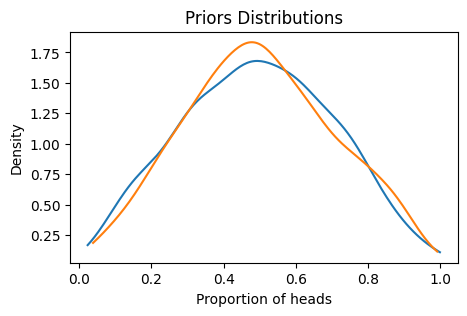

In [97]:
fig, ax = plt.subplots(figsize=(5,3))
sns.kdeplot(sample_prior_x1, ax=ax, cut=0.0)
sns.kdeplot(sample_prior_x2, ax=ax, cut=0.0)
ax.set_title('Priors Distributions')
ax.set_xlabel('Proportion of heads')
plt.show();

In [98]:
sample_prior_pred_k1 = trace2['k1']
sample_prior_pred_k2 = trace2['k2']
sample_prior_pred_k1.mean(), sample_prior_pred_k2.mean()

(123.628, 124.764)

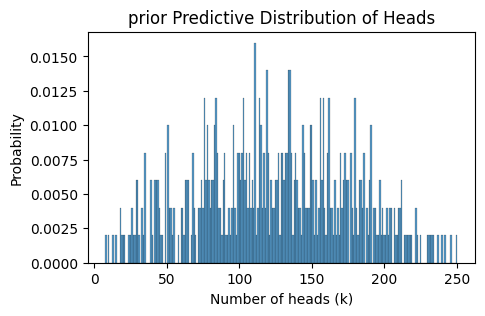

In [99]:
fig, ax = plt.subplots(figsize=(5,3))
sns.histplot(sample_prior_pred_k1, discrete=True, stat='probability', ax=ax)
ax.set_title('prior Predictive Distribution of Heads')
ax.set_xlabel('Number of heads (k)')
plt.show();

### Posterior Predictions

In [100]:
with model2:
    trace2 = pm.sample(500)

/tmp/ipykernel_1165209/3991173879.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [x2, x1, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


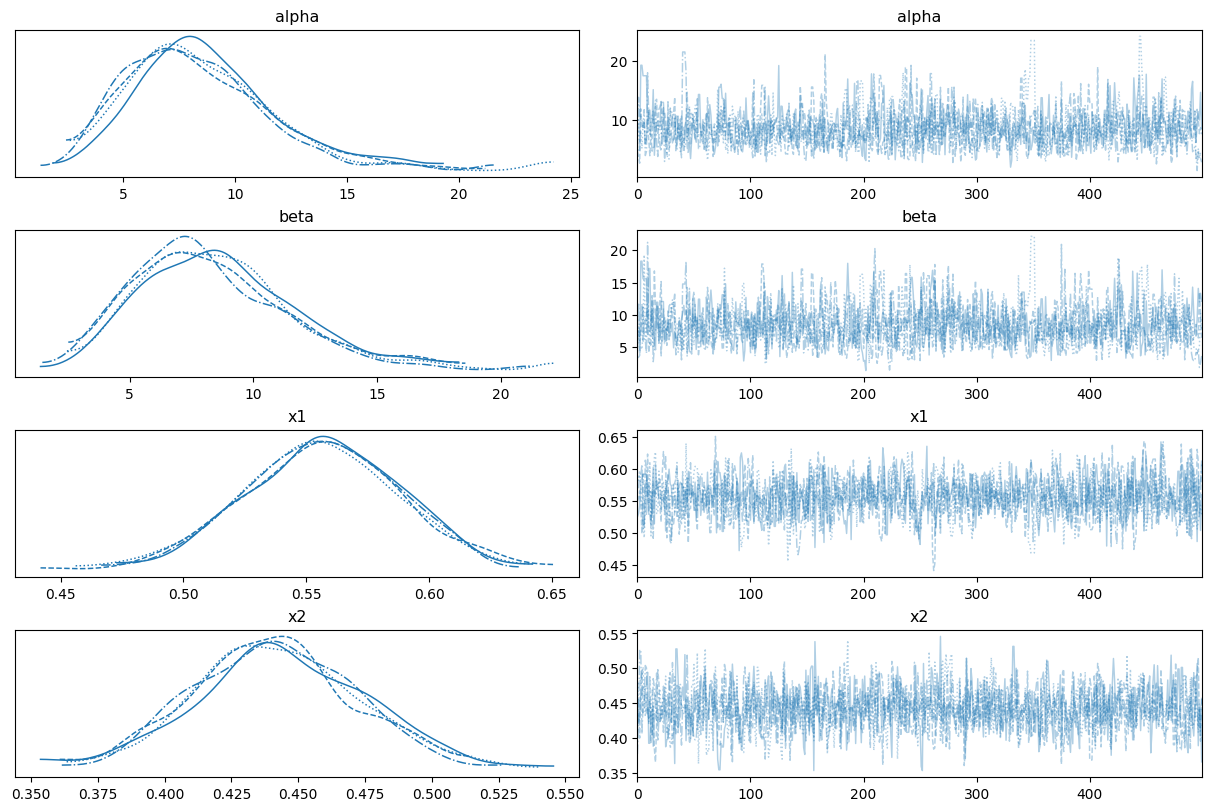

In [101]:
with model2:
    az.plot_trace(trace2)

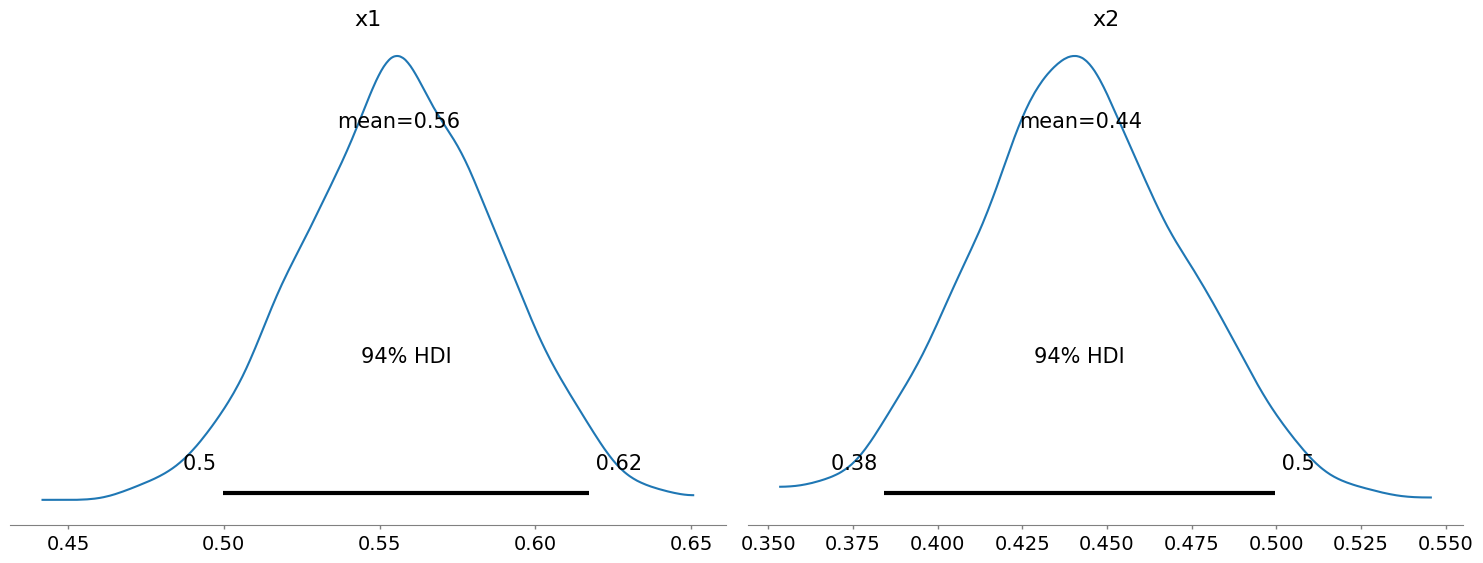

In [102]:
with model2:
    az.plot_posterior(trace2, var_names=['x1', 'x2'])

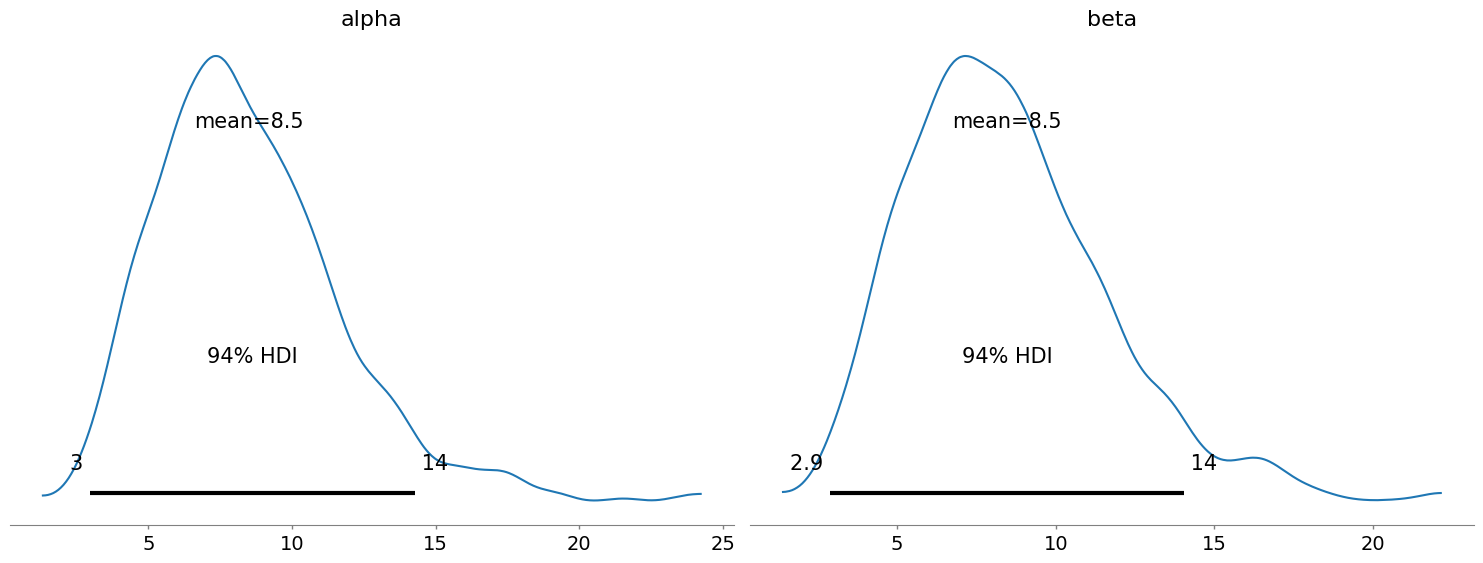

In [103]:
with model2:
    az.plot_posterior(trace2, var_names=['alpha', 'beta'])

+ We can use these to generate a sample from a beta distribution

In [104]:
alphas= trace2['alpha']
betas = trace2['beta']

sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.49778273946790613

+ The result is a distribution that represents what we beleive about coins in general, based on the data from both coins

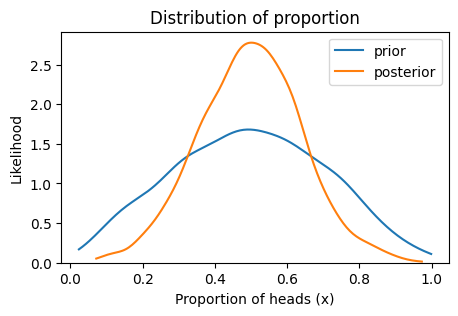

In [105]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.kdeplot(sample_prior_x1, ax=ax, cut=0.0, label='prior')
ax = sns.kdeplot(sample_posterior_x, ax=ax, cut=0.0, label='posterior')
ax.set_title('Distribution of proportion')
ax.set_xlabel('Proportion of heads (x)')
ax.set_ylabel('Likelihood')
plt.legend()
plt.show();

 + The posterior distribution is narrower than the prior, so we have more certainty about plausible values of x. 
 + We think values closer to 0.5 are more likely

# Heart Attack Data

In [106]:
filename = 'data/DeathHeartAttackManhattan.csv'
if not os.path.exists(filename):
    filename = 'DeathHeartAttackManhattan.csv'
    !wget https://github.com/AllenDowney/BayesianInferencePyMC/raw/main/DeathHeartAttackManhattan.csv
df = pd.read_csv(filename)

In [107]:
df

Hospital  Cases  Deaths  Death %
0                       Bellevue Hospital Center    129       4    3.101
1                         Harlem Hospital Center     35       1    2.857
2                            Lenox Hill Hospital    228      18    7.894
3                   Metropolitan Hospital Center     84       7    8.333
4                        Mount Sinai Beth Israel    291      24    8.247
5                           Mount Sinai Hospital    270      16    5.926
6                          Mount Sinai Roosevelt     46       6   13.043
7                         Mount Sinai St. Luke’s    293      19    6.485
8                           NYU Hospitals Center    241      15    6.224
9                  NYP Hospital - Allen Hospital    105      13   12.381
10   NYP Hospital - Columbia Presbyterian Center    353      25    7.082
11  NYP Hospital - New York Weill Cornell Center    250      11    4.400
12                  NYP/Lower Manhattan Hospital     41       4    9.756

In [108]:
data_ns = df['Cases'].values
data_ks = df['Deaths'].values

In [109]:
with pm.Model() as model4:
    alpha = pm.Gamma('alpha', alpha=4, beta=0.5)
    beta = pm.Gamma('beta', alpha=4, beta=0.5)
    xs = pm.Beta('xs', alpha, beta, shape=len(data_ns))
    ks = pm.Binomial('ks', n=data_ns, p=xs, observed=data_ks)
    trace4 = pm.sample(500)

/tmp/ipykernel_1165209/318594488.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [xs, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.


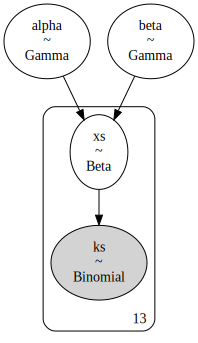

In [110]:
pm.model_to_graphviz(model4)

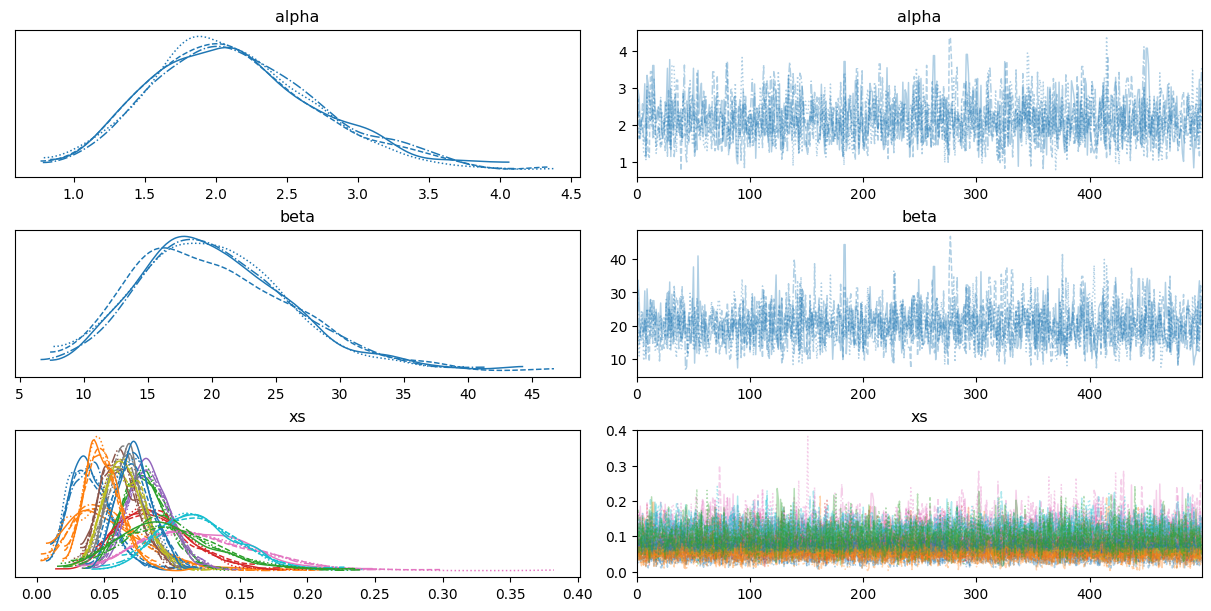

In [111]:
with model4:
    az.plot_trace(trace4)

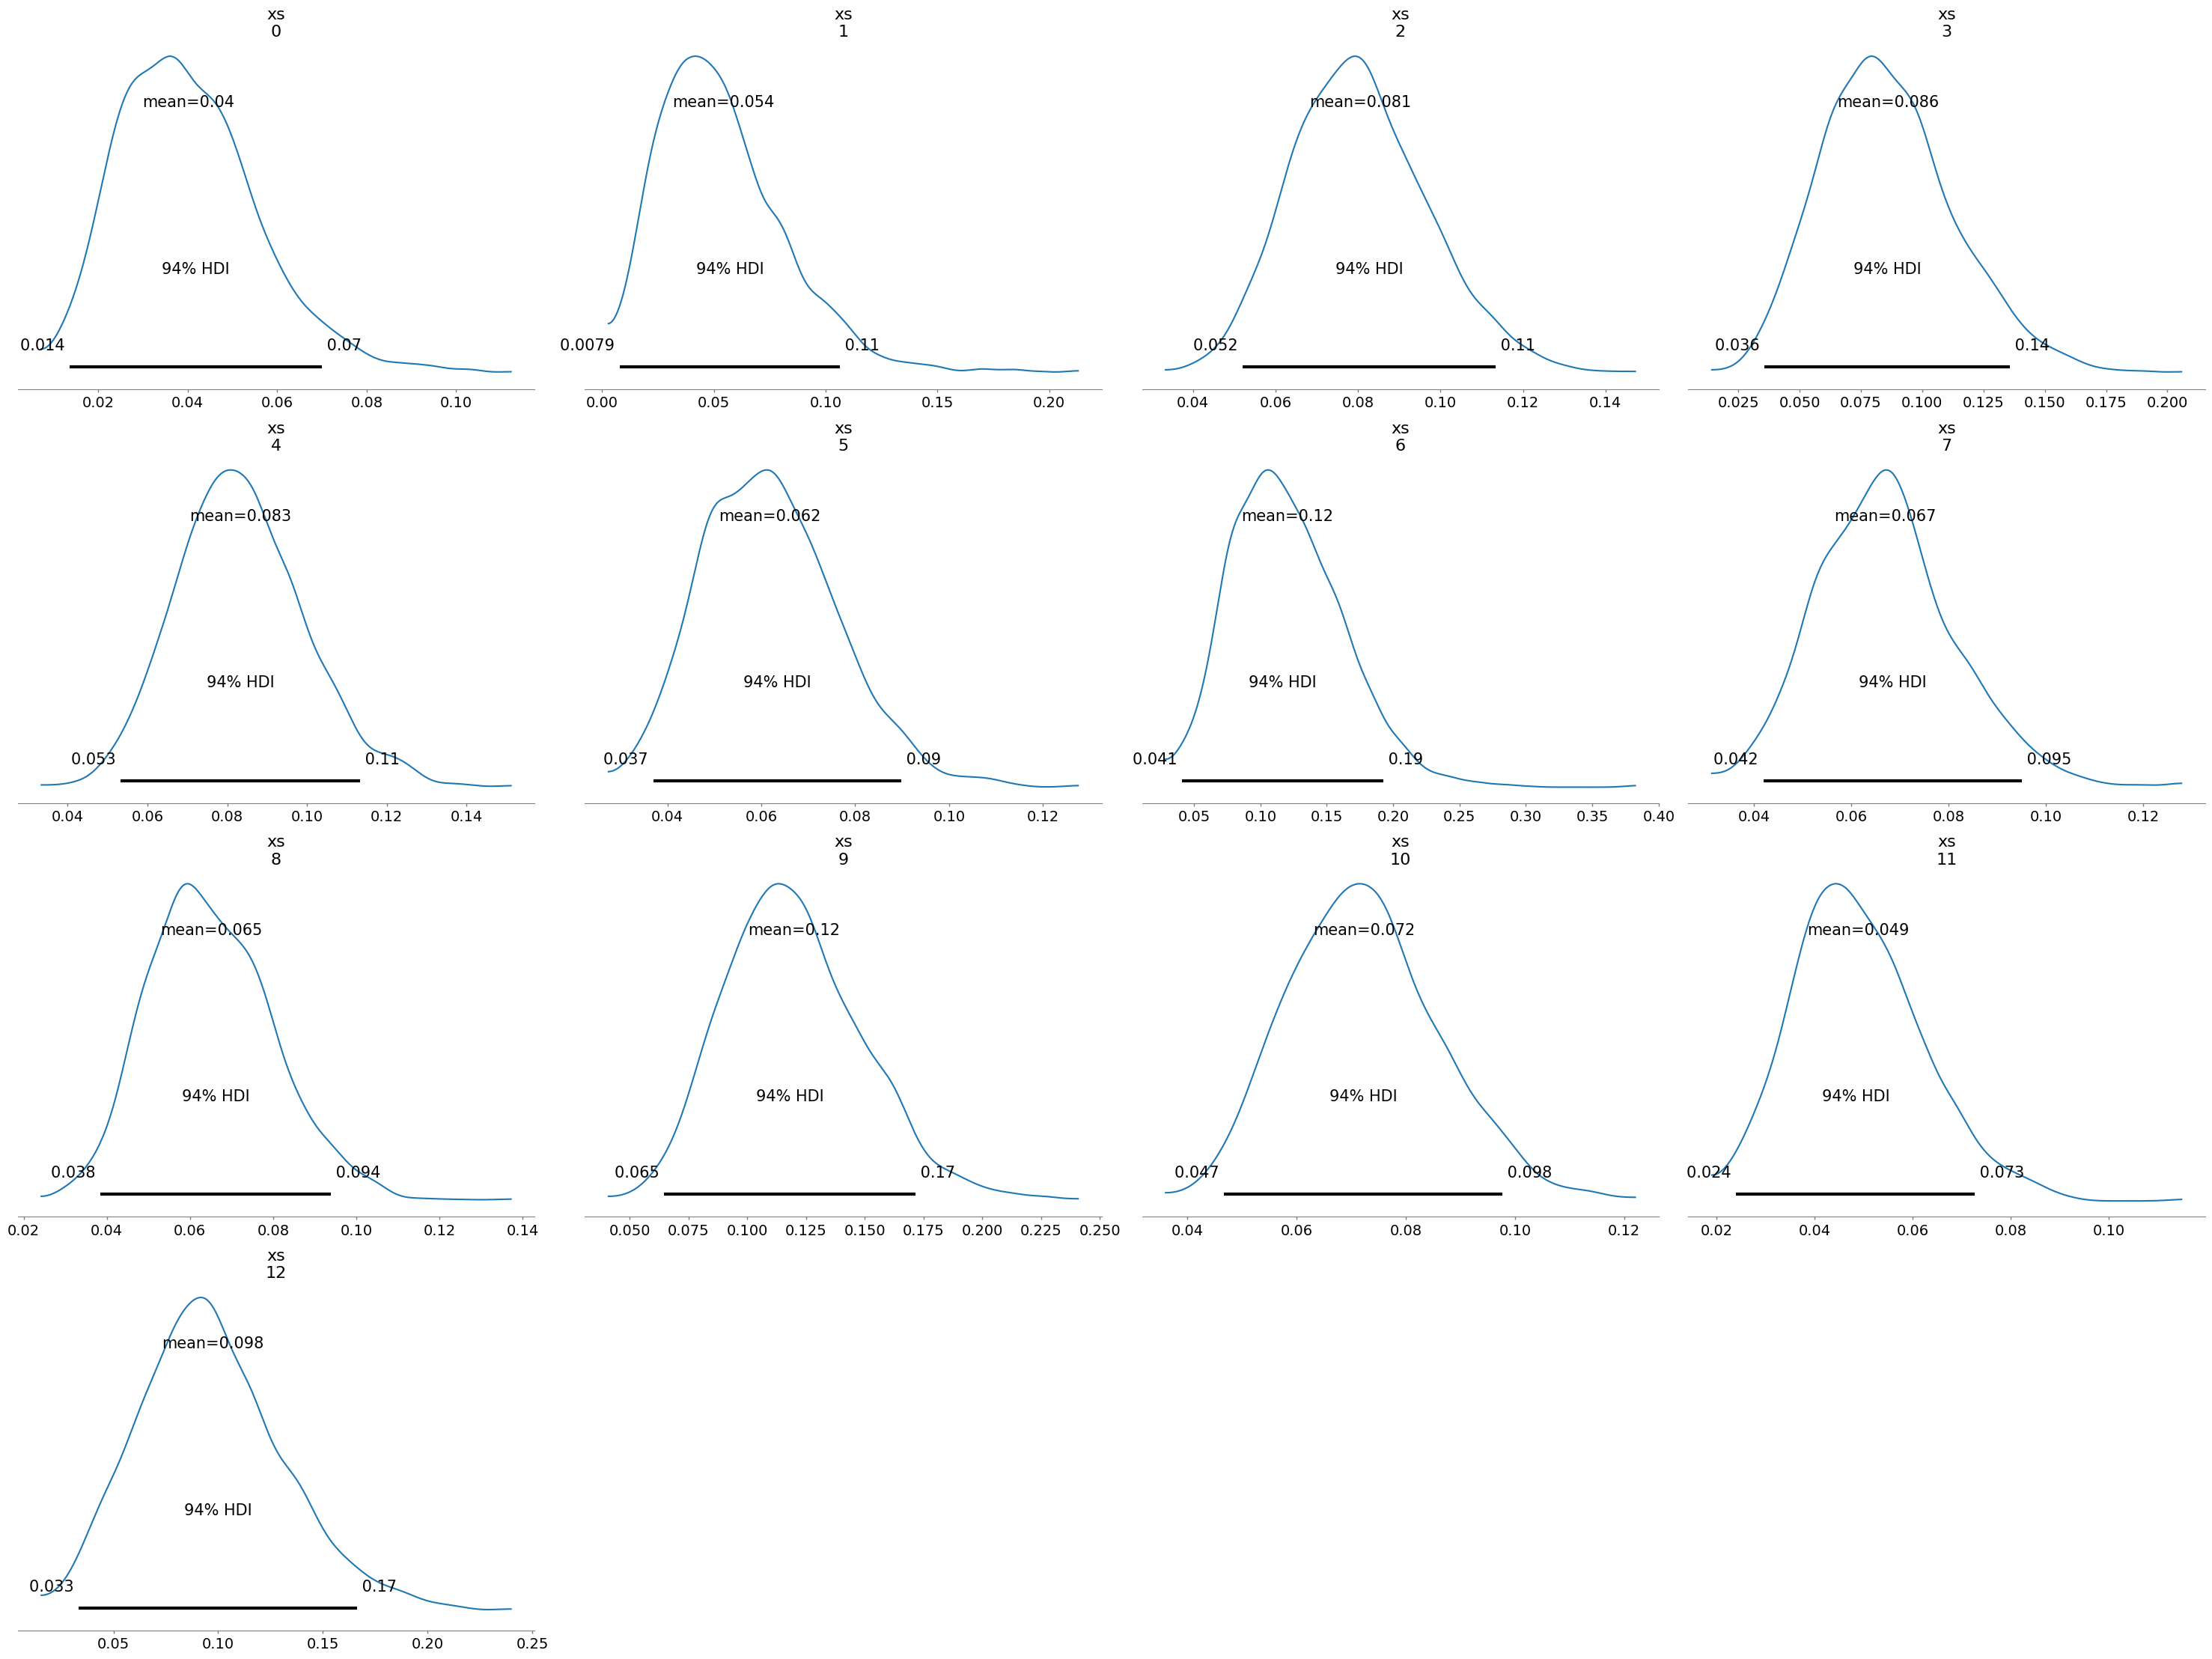

In [112]:
# Posterior Distributions for each Hospital
# Hospitals that treated less patients have wider distributions
with model4:
    az.plot_posterior(trace4, var_names=['xs'])

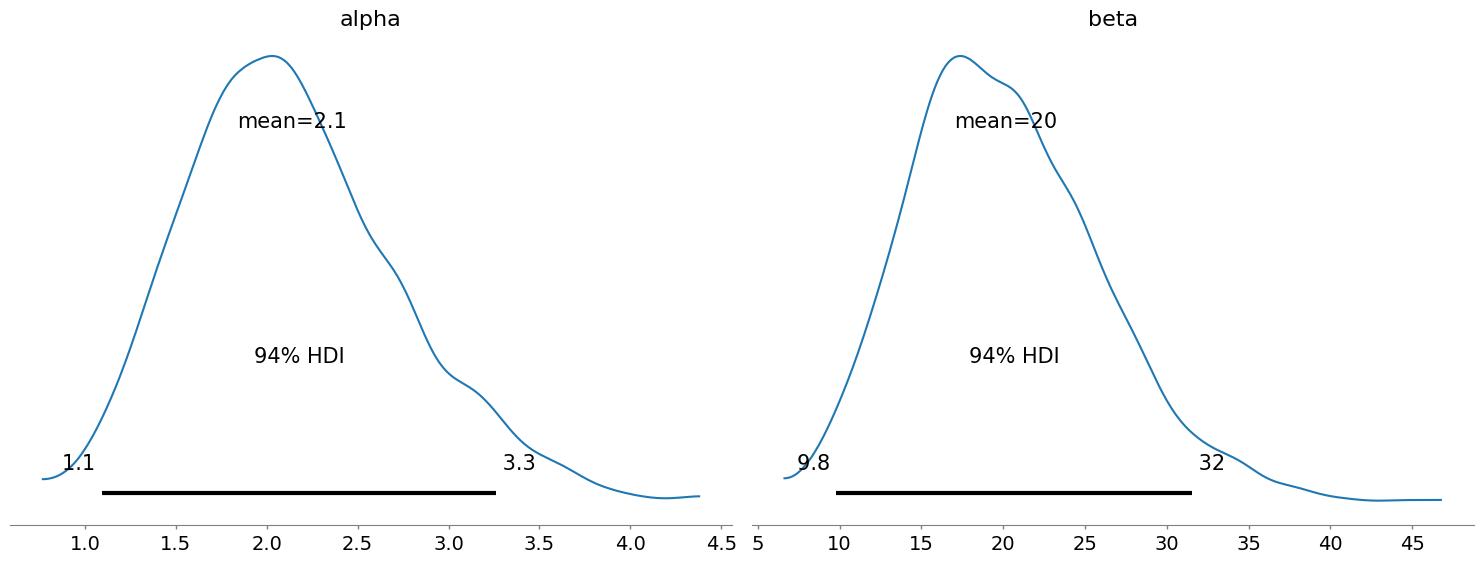

In [113]:
with model4:
    az.plot_posterior(trace4, var_names=['alpha', 'beta'])

In [114]:
alphas = trace4['alpha']
betas = trace4['beta']

In [115]:
sample_posterior_x = pm.Beta.dist(alphas, betas).random()
sample_posterior_x.mean()

0.09961746669206467

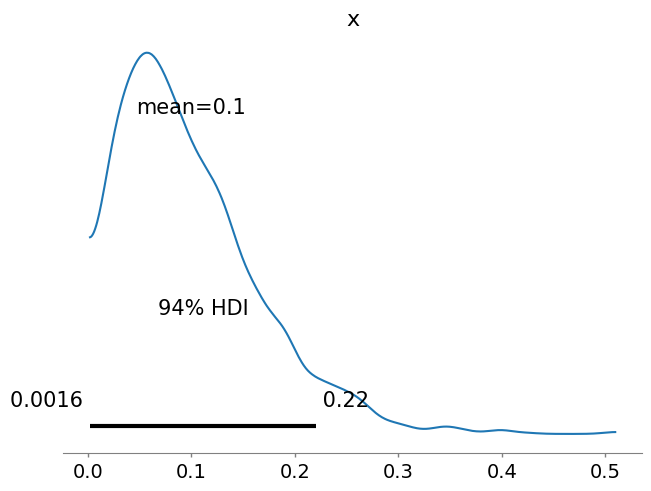

In [116]:
# This shows what we belive about the death rates across all hospitals in the data
with model4:
    az.plot_posterior(sample_posterior_x)

## Poisson model

In [117]:
with pm.Model() as model5:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = pm.Gamma('mu', alpha, beta)
    trace5 = pm.sample_prior_predictive(1000)

In [118]:
sample_prior_mu = trace5['mu']
sample_prior_mu.mean()

9.16437199539553

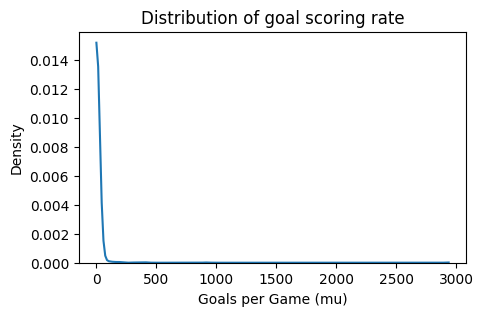

In [119]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.kdeplot(sample_prior_mu, cut=0.0, ax=ax)
ax.set_title('Distribution of goal scoring rate')
ax.set_xlabel('Goals per Game (mu)')
ax.set_ylabel('Density')
plt.show();

+ Higher probabilities for values < 100, but could be higher
+ Very noncommital prior - uninformative
+ Suppose a team plays 1 game an scores 4 goals

In [120]:
with pm.Model() as model6:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[4])

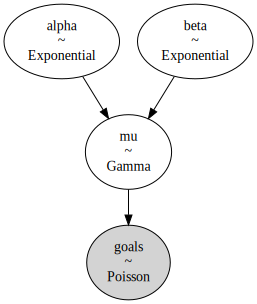

In [121]:
pm.model_to_graphviz(model6)

In [122]:
with model6:
    trace6 = pm.sample(500)

/tmp/ipykernel_1165209/3994245812.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6720367410815379, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


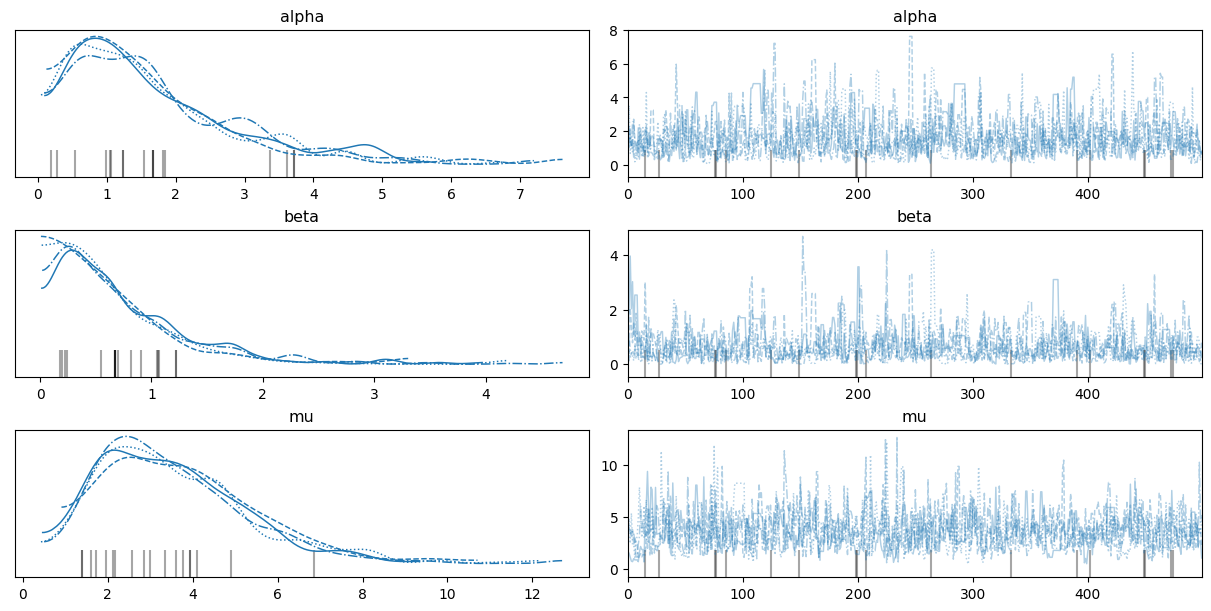

In [123]:
with model6:
    az.plot_trace(trace6)

+ A few divergences, but the trace plots look OK

In [124]:
sample_post_mu = trace6['mu']
sample_post_mu.mean()

3.6129016806088066

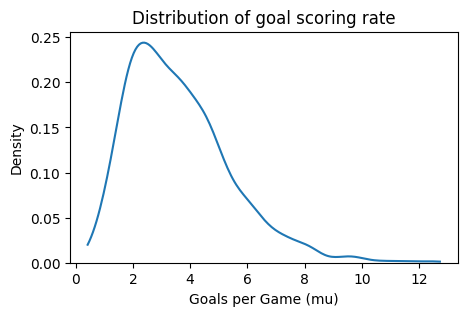

In [125]:
fig, ax = plt.subplots(figsize=(5, 3))
sns.kdeplot(sample_post_mu, cut=0.0)
ax.set_title('Distribution of goal scoring rate')
ax.set_xlabel('Goals per Game (mu)')
plt.show();

### Two teams 

In [126]:
with pm.Model() as model7:
    # hyperpriors
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    # priors
    mu_A = pm.Gamma('mu_A', alpha, beta)
    mu_B = pm.Gamma('mu_B', alpha, beta)
    
    goals_A = pm.Poisson('goals_A', mu_A, observed=[5, 3])
    goals_B = pm.Poisson('goals_B', mu_B, observed=[1, 1])
    trace7 = pm.sample(500) 

/tmp/ipykernel_1165209/3523907522.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_B, mu_A, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


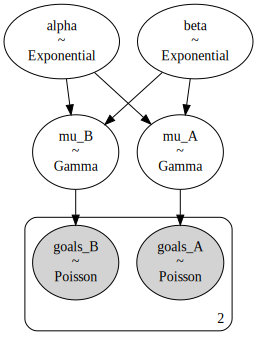

In [127]:
pm.model_to_graphviz(model7)

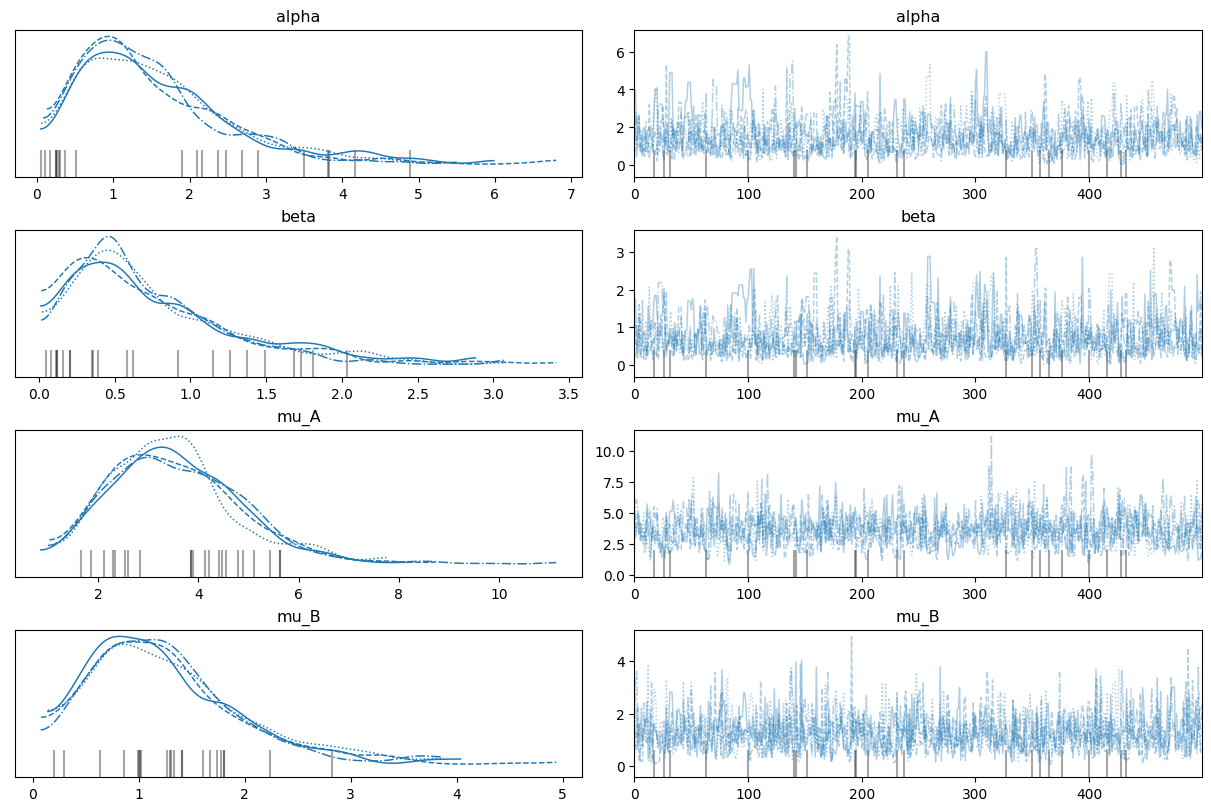

In [128]:
with model7:
    az.plot_trace(trace7)

In [129]:
mu_A = trace7['mu_A']
mu_B = trace7['mu_B']
mu_B.mean(), mu_A.mean()

(1.2545055357251271, 3.544717113730001)

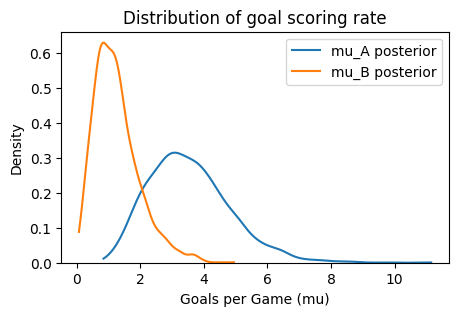

In [130]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.kdeplot(mu_A, ax=ax, cut=0.0, label='mu_A posterior')
ax = sns.kdeplot(mu_B, ax=ax, cut=0.0, label='mu_B posterior')
ax.set_title('Distribution of goal scoring rate')
ax.set_xlabel('Goals per Game (mu)')
ax.set_ylabel('Density')
plt.legend()
plt.show();

In [131]:
# Probability that A is the better team
(mu_A > mu_B).mean()

0.9665

## More background
+ Results from Stanley Cup finals

In [132]:
data = dict(BOS13 = [3, 1, 2, 5, 1, 2],
            CHI13 = [3, 1, 0, 5, 3, 3],
            NYR14 = [2, 4, 0, 2, 2],
            LAK14 = [2, 4, 3, 1, 2],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 2, 1, 4, 1],
            PIT16 = [3, 1, 2, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            STL19 = [2, 2, 2, 4, 2, 1, 4],
            BOS19 = [4, 2, 7, 2, 1, 5, 1],
            DAL20 = [4, 2, 2, 4, 2, 0],
            TBL20 = [1, 3, 5, 4, 2, 2],
            MTL21 = [1, 1, 3, 2, 0],
            TBL21 = [5, 3, 6, 2, 1])

In [133]:
with pm.Model() as model8:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace8 = pm.sample(500)

/tmp/ipykernel_1165209/1025017370.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_TBL21, mu_MTL21, mu_TBL20, mu_DAL20, mu_BOS19, mu_STL19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 7 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8868693185699388, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


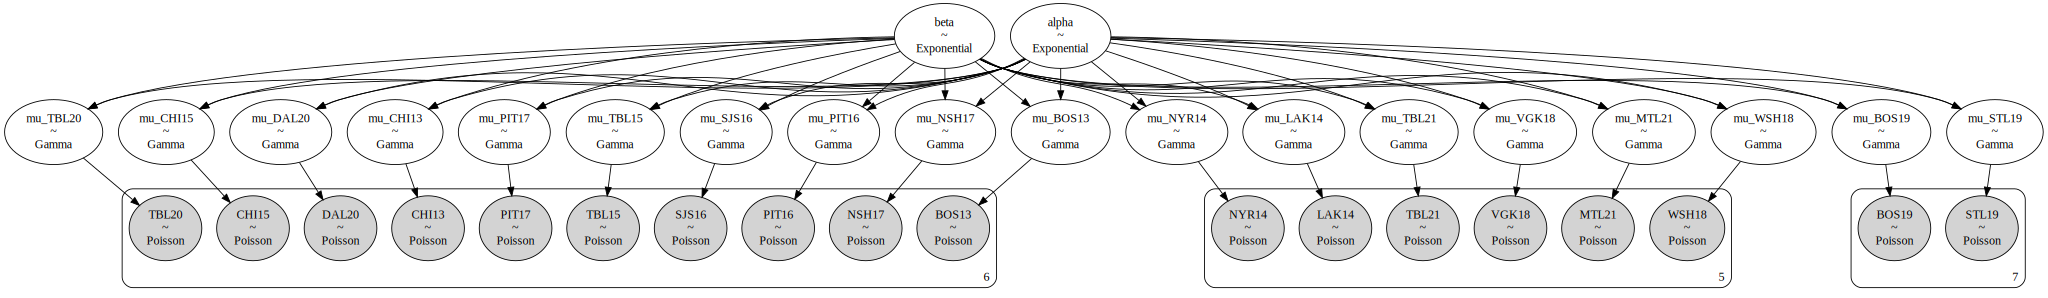

In [134]:
viz = pm.model_to_graphviz(model8)
viz

In [135]:
sample_post_alpha = trace8['alpha']
sample_post_alpha.mean()

5.173398808497679

In [136]:
sample_post_beta = trace8['beta']
sample_post_beta.mean()

2.0423165048722347

In [137]:
sample_post_mu_TBL21 = trace8['mu_TBL21']
sample_post_mu_MTL21 = trace8['mu_MTL21']
sample_post_mu_TBL21.mean(), sample_post_mu_MTL21.mean()

(3.137894050695505, 1.7361996251199432)

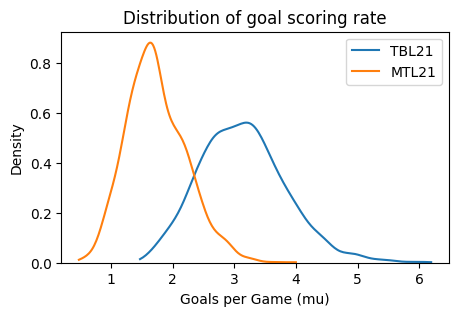

In [138]:
fig, ax = plt.subplots(figsize=(5,3))
ax = sns.kdeplot(sample_post_mu_TBL21, ax=ax, cut=0.0, label='TBL21')
ax = sns.kdeplot(sample_post_mu_MTL21, ax=ax, cut=0.0, label='MTL21')
ax.set_title('Distribution of goal scoring rate')
ax.set_xlabel('Goals per Game (mu)')
ax.set_ylabel('Density')
plt.legend()
plt.show();

In [139]:
# probability that Tampa bay is the better team
(sample_post_mu_TBL21 > sample_post_mu_MTL21).mean()

0.958